**Mount google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive
drive.mount('/content/drive')

!nvidia-smi

!ls /content/drive/MyDrive/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 1: nvidia-smi: command not found
fit  preprocessed  ringdown


**1) Data prep + group-aware split**

In [ ]:
# === Load + prepare data for pressure regression (predict pressure from fitted params) ===
import os, json
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------- Paths ----------------
replicate = 1
variant   = "lowering"
FIT_DIR   = "/content/drive/MyDrive/data/fit"
PREP_DIR  = "/content/drive/MyDrive/data/preprocessed"

# use BANK-CORRECTED merged file
MERGED_FP  = os.path.join(FIT_DIR, f"merged_rep_{replicate}_{variant}_bankcorrected_params6_Q_rmse_nrmse.npz")
PRESS_JSON = os.path.join(PREP_DIR, f"pressures_replicate_{replicate}_{variant}.json")
NOZZ_JSON  = os.path.join(PREP_DIR, f"nozzles_replicate_{replicate}_{variant}.json")

m = np.load(MERGED_FP, allow_pickle=True)
params6   = m["params6_all"]    # (N,P,6) -> [A, tau(s), f(Hz), phi(rad), C, D]
pressures = m["pressures"].astype(float)  # (P,)
nozzles   = m["nozzles"]                  # (N,)

N, P, _ = params6.shape
print(f"Loaded params6: {params6.shape} (N nozzles x P pressures x 6 params)")

# ---------------- Build a tidy dataframe ----------------
# Flatten grid (N,P) to rows (N*P, ...)
ii, jj = np.meshgrid(np.arange(N), np.arange(P), indexing="ij")
df = pd.DataFrame({
    "nozzle_idx": ii.ravel().astype(int),
    "pressure_idx": jj.ravel().astype(int),
    "pressure_mBar": pressures[jj].ravel().astype(float),
    "A":   params6[:,:,0].ravel(),
    "tau": params6[:,:,1].ravel(),  # seconds
    "f":   params6[:,:,2].ravel(),  # Hz
    "phi": params6[:,:,3].ravel(),  # rad
    "C":   params6[:,:,4].ravel(),
    "D":   params6[:,:,5].ravel(),
})

# Final feature set — keep original 6 fitted parameters
base_feats = ["A","tau","f","phi","C","D"]
FEATS      = base_feats

X = df[FEATS].copy()
y = df["pressure_mBar"].astype(float).values
groups = df["nozzle_idx"].values  # group by nozzle to avoid leakage across splits

print("Feature columns:", FEATS)
print("X shape:", X.shape, "| y shape:", y.shape, "| groups unique nozzles:", np.unique(groups).size)

# ---------------- Group-aware split: train/test by nozzle ----------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, y_train, g_train = X.iloc[train_idx], y[train_idx], groups[train_idx]
X_test,  y_test,  g_test  = X.iloc[test_idx],  y[test_idx],  groups[test_idx]

print(f"Train rows: {len(X_train)}, Test rows: {len(X_test)}")
print(f"Train nozzles: {np.unique(g_train).size}, Test nozzles: {np.unique(g_test).size}")



Loaded params6: (1280, 95, 6) (N nozzles x P pressures x 6 params)
Feature columns: ['A', 'tau', 'f', 'phi', 'C', 'D']
X shape: (121600, 6) | y shape: (121600,) | groups unique nozzles: 1280
Train rows: 97280, Test rows: 24320
Train nozzles: 1024, Test nozzles: 256


**2) Models + grouped CV + evaluation**

In [ ]:
# === FAST model training with grouped CV (Ridge + HistGBR) ===
import numpy as np
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import loguniform
import time

# -------- toggles --------
FAST = False            # smaller search on fewer groups (much faster)
CV_FOLDS = 3 if FAST else 5
RIDGE_ITERS = 20 if FAST else 50
HGBR_ITERS  = 20 if FAST else 60
SUBSET_FRAC = 0.35 if FAST else 1.0   # fraction of train nozzles used for CV
RANDOM_STATE = 42

# -------- expect X_train, y_train, g_train, X_test, y_test, g_test to exist --------
# If not, rebuild a grouped split quickly from df/FEATS/y/groups:
try:
    X_train
except NameError:
    print("ℹ️ Rebuilding grouped split…")
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
    train_idx, test_idx = next(gss.split(X, y, groups=groups))
    X_train, y_train, g_train = X.iloc[train_idx], y[train_idx], groups[train_idx]
    X_test,  y_test,  g_test  = X.iloc[test_idx],  y[test_idx],  groups[test_idx]

# -------- optionally subset train by nozzle for CV to speed up --------
rng = np.random.default_rng(RANDOM_STATE)
unique_nozz = np.unique(g_train)
if SUBSET_FRAC < 1.0:
    keep_nozz = rng.choice(unique_nozz, size=max(1, int(len(unique_nozz)*SUBSET_FRAC)), replace=False)
    mask_keep = np.isin(g_train, keep_nozz)
    X_cv, y_cv, g_cv = X_train.iloc[mask_keep], y_train[mask_keep], g_train[mask_keep]
    print(f"⚡ Using {len(keep_nozz)}/{len(unique_nozz)} train nozzles for CV "
          f"({mask_keep.sum()} rows). Will refit best on full train.")
else:
    X_cv, y_cv, g_cv = X_train, y_train, g_train

# -------- common preprocessors --------
num_pre = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  RobustScaler())
])

# -------- Ridge (linear baseline) --------
ridge_pipe = Pipeline(steps=[
    ("prep",  num_pre),
    ("model", Ridge(random_state=RANDOM_STATE))
])

ridge_param_dist = {"model__alpha": loguniform(1e-4, 1e2)}

t0 = time.time()
ridge_search = RandomizedSearchCV(
    estimator=ridge_pipe,
    param_distributions=ridge_param_dist,
    n_iter=RIDGE_ITERS,
    scoring="neg_mean_absolute_error",
    cv=GroupKFold(n_splits=CV_FOLDS).split(X_cv, y_cv, groups=g_cv),
    refit=True,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
ridge_search.fit(X_cv, y_cv)
ridge_best = ridge_search.best_estimator_
t_ridge = time.time() - t0
print(f"Ridge best params: {ridge_search.best_params_}  (search {t_ridge:.1f}s)")

# Refit best Ridge on full train
ridge_best.fit(X_train, y_train)

# -------- HistGradientBoostingRegressor (fast trees with early stopping) --------
hgb_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=20,
        max_bins=255
    ))
])

hgb_param_dist = {
    "model__learning_rate": [0.03, 0.05, 0.08, 0.1],
    "model__max_depth":     [None, 3, 5, 7],
    "model__max_leaf_nodes":[31, 63, 127],
    "model__min_samples_leaf":[20, 50, 100],
    "model__l2_regularization": [0.0, 1e-3, 1e-2, 1e-1],
}

t0 = time.time()
hgb_search = RandomizedSearchCV(
    estimator=hgb_pipe,
    param_distributions=hgb_param_dist,
    n_iter=HGBR_ITERS,
    scoring="neg_mean_absolute_error",
    cv=GroupKFold(n_splits=CV_FOLDS).split(X_cv, y_cv, groups=g_cv),
    refit=True,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
hgb_search.fit(X_cv, y_cv)
hgb_best = hgb_search.best_estimator_
t_hgb = time.time() - t0
print(f"HGB best params: {hgb_search.best_params_}  (search {t_hgb:.1f}s)")

# Refit best HGB on full train
hgb_best.fit(X_train, y_train)

# --- Evaluation on held-out test ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def eval_model(name, mdl):
    y_pred = mdl.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # manual sqrt
    r2 = r2_score(y_test, y_pred)
    print(f"{name:>6} | Test MAE: {mae:.2f} mBar | RMSE: {rmse:.2f} mBar | R^2: {r2:.3f}")
    return y_pred, mae, rmse, r2

ypr_ridge, mae_r, rmse_r, r2_r = eval_model("Ridge", ridge_best)
ypr_hgb,   mae_h, rmse_h, r2_h = eval_model("HGB",   hgb_best)

best_name, best_model, best_pred = ("HGB", hgb_best, ypr_hgb) if mae_h < mae_r else ("Ridge", ridge_best, ypr_ridge)
print(f"\n🏆 Best model on held-out test: {best_name}")


Ridge best params: {'model__alpha': np.float64(0.00013289448722869195)}  (search 27.6s)
HGB best params: {'model__min_samples_leaf': 50, 'model__max_leaf_nodes': 127, 'model__max_depth': None, 'model__learning_rate': 0.1, 'model__l2_regularization': 0.001}  (search 308.2s)
 Ridge | Test MAE: 9.39 mBar | RMSE: 10.88 mBar | R^2: 0.017
   HGB | Test MAE: 6.09 mBar | RMSE: 7.71 mBar | R^2: 0.506

🏆 Best model on held-out test: HGB


**3) Plot**

Ridge | R^2=0.017  MAE=9.39 mBar  RMSE=10.88 mBar


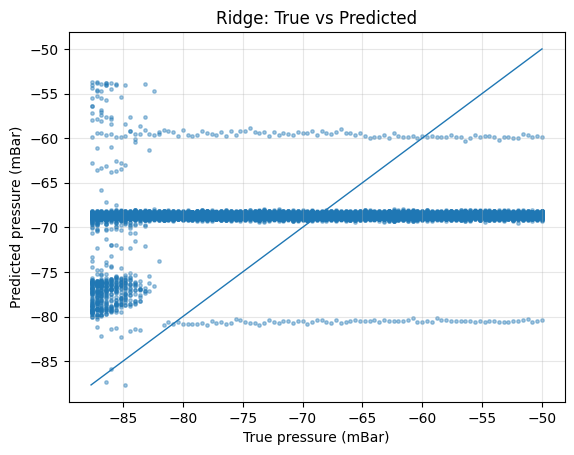

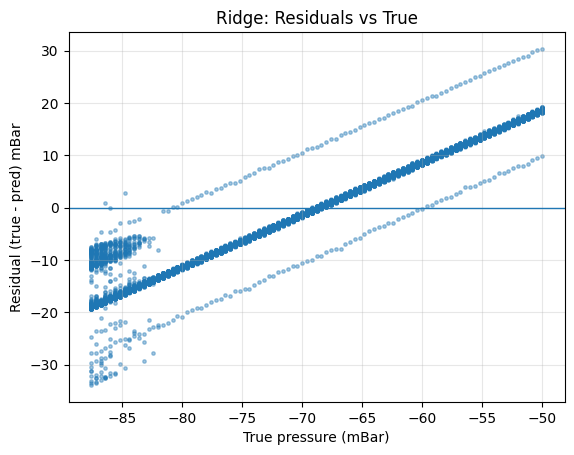

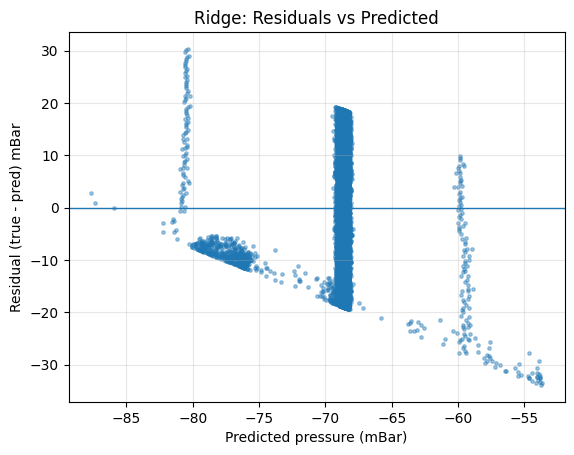

/tmp/ipython-input-2026799452.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = pd.DataFrame({"yhat": yhat, "y": yte}).groupby(bins).agg(


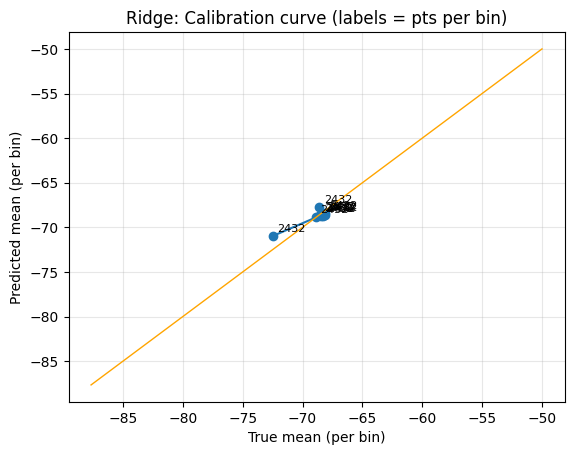

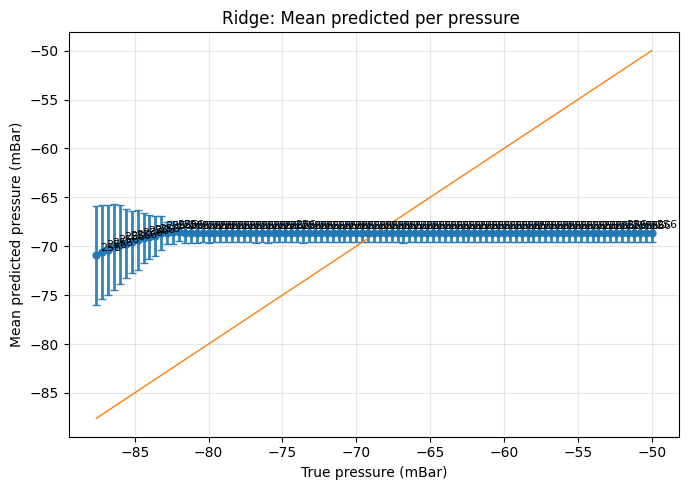

Ridge per-nozzle median residuals — mean -0.15, std 0.95, min -9.24, max 11.61 mBar


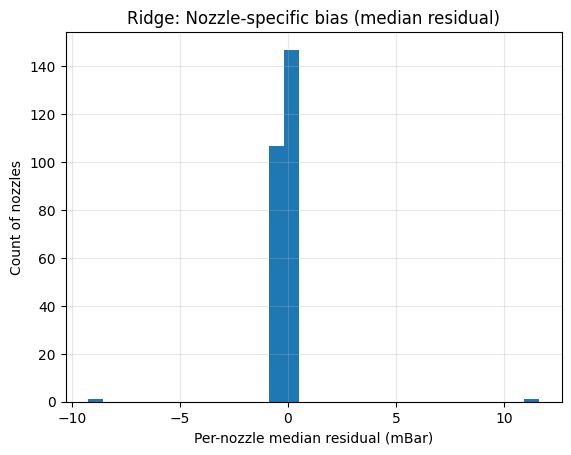

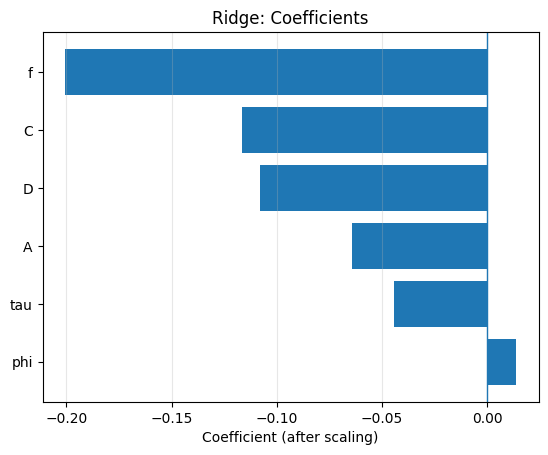

  HGB | R^2=0.506  MAE=6.09 mBar  RMSE=7.71 mBar


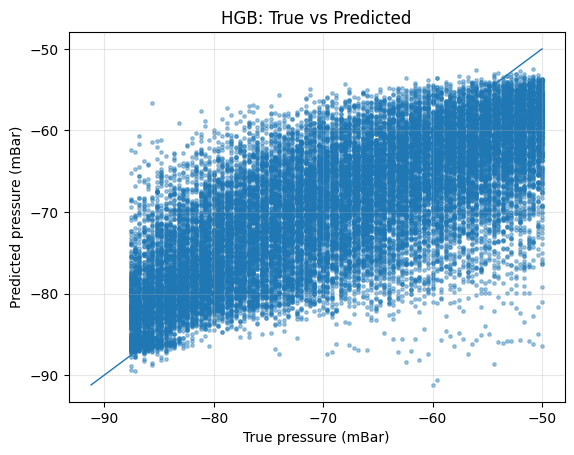

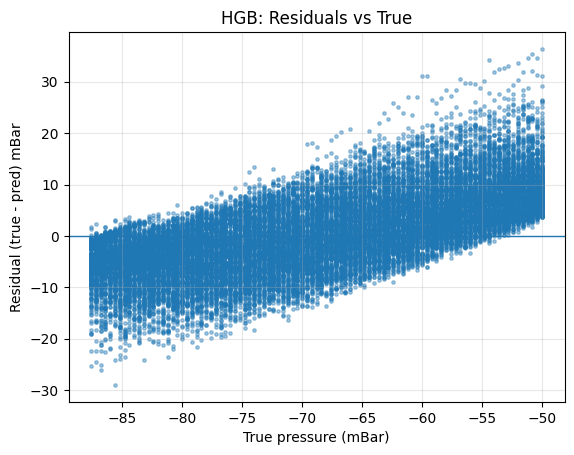

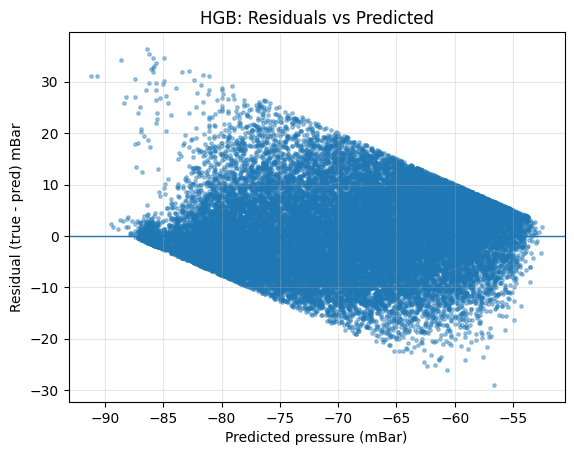

/tmp/ipython-input-2026799452.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = pd.DataFrame({"yhat": yhat, "y": yte}).groupby(bins).agg(


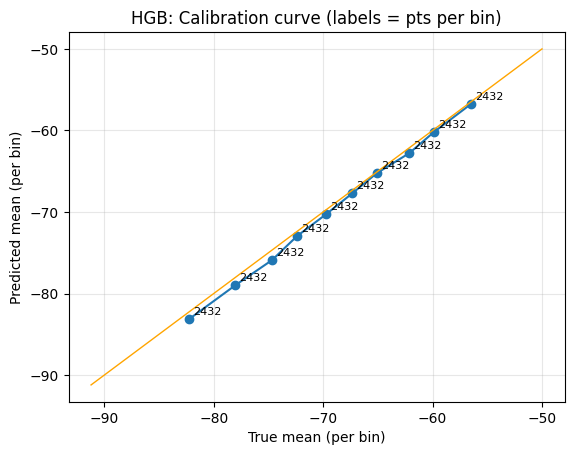

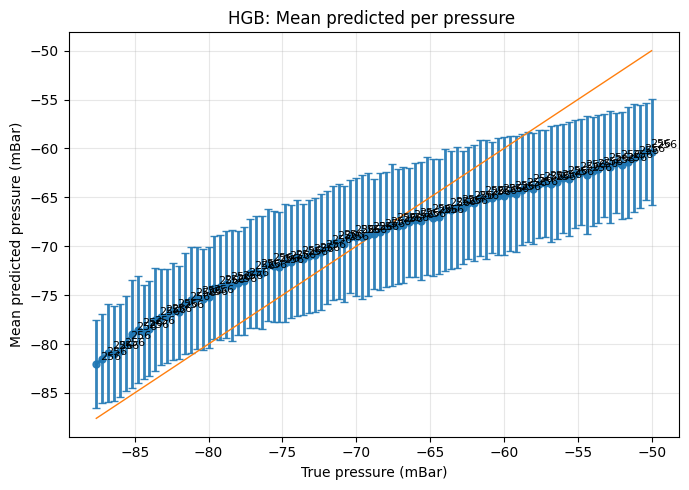

HGB per-nozzle median residuals — mean 0.34, std 4.22, min -10.27, max 13.42 mBar


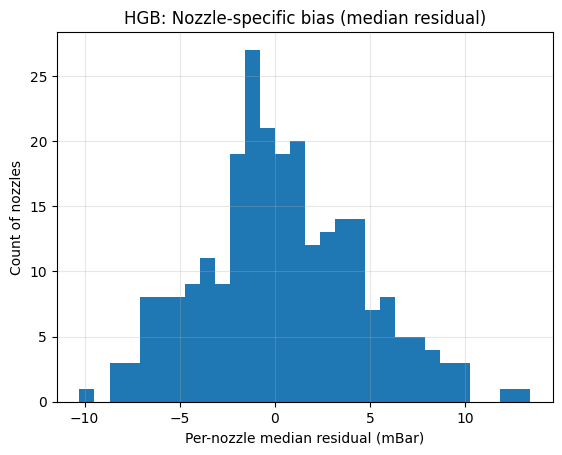


=== Test metrics ===


,R2,MAE_mBar,RMSE_mBar
Model,,,
Ridge,0.017059,9.391232,10.875083
HGB,0.506039,6.089687,7.709305


In [ ]:
# === DIAGNOSTIC PLOTS FOR BOTH MODELS (Ridge + HGB) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

models = {
    "Ridge": ridge_best,
    "HGB":   hgb_best,
}

Xte = X_test
yte = y_test
feat_names = list(Xte.columns)

rows = []

def save_show(fname):
    plt.savefig(fname, dpi=150, bbox_inches="tight")
    plt.show()

for name, model in models.items():
    # predictions + residuals
    yhat = model.predict(Xte)
    res  = yte - yhat

    # metrics
    R2   = r2_score(yte, yhat)
    MAE  = mean_absolute_error(yte, yhat)
    RMSE = np.sqrt(mean_squared_error(yte, yhat))
    rows.append([name, R2, MAE, RMSE])
    print(f"{name:>5} | R^2={R2:.3f}  MAE={MAE:.2f} mBar  RMSE={RMSE:.2f} mBar")

    # 1) True vs Predicted
    plt.figure()
    plt.scatter(yte, yhat, s=6, alpha=0.4)
    lims = [min(yte.min(), yhat.min()), max(yte.max(), yhat.max())]
    plt.plot(lims, lims, lw=1)
    plt.xlabel("True pressure (mBar)"); plt.ylabel("Predicted pressure (mBar)")
    plt.title(f"{name}: True vs Predicted")
    plt.grid(True, alpha=0.3)
    save_show(f"{name}_true_vs_pred.png")

    # 2) Residuals vs True
    plt.figure()
    plt.scatter(yte, res, s=6, alpha=0.4)
    plt.axhline(0, lw=1)
    plt.xlabel("True pressure (mBar)"); plt.ylabel("Residual (true - pred) mBar")
    plt.title(f"{name}: Residuals vs True")
    plt.grid(True, alpha=0.3)
    save_show(f"{name}_residuals_vs_true.png")

    # 3) Residuals vs Predicted (calibration check)
    plt.figure()
    plt.scatter(yhat, res, s=6, alpha=0.4)
    plt.axhline(0, lw=1)
    plt.xlabel("Predicted pressure (mBar)"); plt.ylabel("Residual (true - pred) mBar")
    plt.title(f"{name}: Residuals vs Predicted")
    plt.grid(True, alpha=0.3)
    save_show(f"{name}_residuals_vs_pred.png")

    # 4) Binned calibration curve (mean predicted vs mean true) — AXES SWITCHED
    q = np.linspace(0, 1, 11)
    edges = np.quantile(yhat, q)
    bins = pd.cut(yhat, bins=np.unique(edges), include_lowest=True)
    calib = pd.DataFrame({"yhat": yhat, "y": yte}).groupby(bins).agg(
        yhat_mean=("yhat","mean"), y_mean=("y","mean"), count=("y","size")
    ).dropna()

    plt.figure()
    plt.plot(calib["y_mean"], calib["yhat_mean"], marker="o")  # <-- swapped
    lims = [min(yte.min(), yhat.min()), max(yte.max(), yhat.max())]
    plt.plot(lims, lims, lw=1, color="orange")  # identity line (now x=y)
    for i, n in enumerate(calib["count"].values):
        plt.annotate(
            str(int(n)),
            (calib["y_mean"].values[i], calib["yhat_mean"].values[i]),
            textcoords="offset points", xytext=(3,3), fontsize=8
        )

    plt.xlabel("True mean (per bin)")
    plt.ylabel("Predicted mean (per bin)")
    plt.title(f"{name}: Calibration curve (labels = pts per bin)")
    plt.grid(True, alpha=0.3)
    save_show(f"{name}_calibration_curve_swapped.png")

    # 4b) NEW: Per-pressure mean predictions (no binning)
    per_pressure = (
        pd.DataFrame({"true_p": np.round(yte, 6), "pred_p": yhat})
        .groupby("true_p")
        .agg(pred_mean=("pred_p","mean"), pred_std=("pred_p","std"), count=("pred_p","size"))
        .reset_index()
        .sort_values("true_p")
    )
    plt.figure(figsize=(7,5))
    yerr = per_pressure["pred_std"].fillna(0.0).values
    plt.errorbar(per_pressure["true_p"], per_pressure["pred_mean"], yerr=yerr,
                 fmt="o-", capsize=3, lw=2, ms=5, alpha=0.9)
    lims = [min(per_pressure["true_p"].min(), per_pressure["pred_mean"].min()),
            max(per_pressure["true_p"].max(), per_pressure["pred_mean"].max())]
    plt.plot(lims, lims, lw=1)
    for _, r in per_pressure.iterrows():
        plt.annotate(str(int(r["count"])), (r["true_p"], r["pred_mean"]),
                     textcoords="offset points", xytext=(3,3), fontsize=8)
    plt.xlabel("True pressure (mBar)")
    plt.ylabel("Mean predicted pressure (mBar)")
    plt.title(f"{name}: Mean predicted per pressure ")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    save_show(f"{name}_per_pressure_mean.png")

    # 5) Per-nozzle median residuals (bias distribution)
    res_df = pd.DataFrame({"nozzle_idx": g_test, "residual": res})
    by_noz = res_df.groupby("nozzle_idx")["residual"].median()
    print(f"{name} per-nozzle median residuals — mean {by_noz.mean():.2f}, "
          f"std {by_noz.std():.2f}, min {by_noz.min():.2f}, max {by_noz.max():.2f} mBar")
    plt.figure()
    plt.hist(by_noz.values, bins=30)
    plt.xlabel("Per-nozzle median residual (mBar)"); plt.ylabel("Count of nozzles")
    plt.title(f"{name}: Nozzle-specific bias (median residual)")
    plt.grid(True, alpha=0.3)
    save_show(f"{name}_nozzle_bias_hist.png")

    # 6a) Feature importances for HGB
    try:
        fi = model.named_steps["model"].feature_importances_
        order = np.argsort(fi)
        plt.figure()
        plt.barh(np.array(feat_names)[order], fi[order])
        plt.xlabel("Relative importance")
        plt.title(f"{name}: Feature importances")
        plt.grid(True, axis="x", alpha=0.3)
        save_show(f"{name}_feature_importances.png")
    except Exception:
        pass

    # 6b) Coefficients for Ridge (on scaled features)
    try:
        coef = model.named_steps["model"].coef_
        order = np.argsort(np.abs(coef))
        plt.figure()
        plt.barh(np.array(feat_names)[order], coef[order])
        plt.axvline(0, lw=1)
        plt.xlabel("Coefficient (after scaling)")
        plt.title(f"{name}: Coefficients")
        plt.grid(True, axis="x", alpha=0.3)
        save_show(f"{name}_coefficients.png")
    except Exception:
        pass

metrics = pd.DataFrame(rows, columns=["Model","R2","MAE_mBar","RMSE_mBar"]).set_index("Model")
print("\n=== Test metrics ===")
display(metrics)



**Feature importance HGB**

 phi: 1.1887 ± 0.0074
   C: 0.3779 ± 0.0051
   f: 0.2864 ± 0.0027
   D: 0.1239 ± 0.0027
   A: 0.0512 ± 0.0014
 tau: 0.0221 ± 0.0010


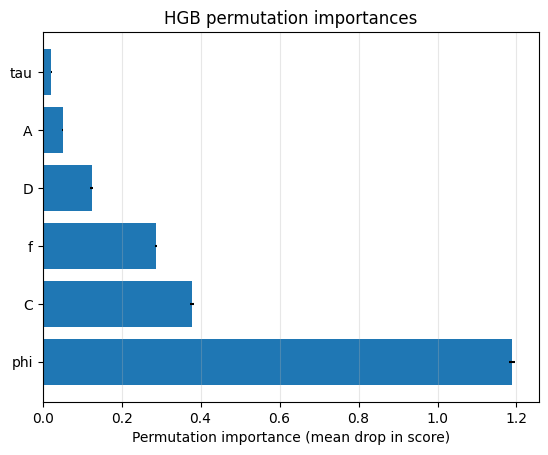

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

feat_names = list(X_test.columns)

r = permutation_importance(
    hgb_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

imp_mean = r.importances_mean
imp_std  = r.importances_std
order = np.argsort(imp_mean)[::-1]

# Text summary
for i in order:
    print(f"{feat_names[i]:>4}: {imp_mean[i]:.4f} ± {imp_std[i]:.4f}")

# Bar plot
plt.figure()
plt.barh(np.array(feat_names)[order], imp_mean[order], xerr=imp_std[order])
plt.xlabel("Permutation importance (mean drop in score)")
plt.title("HGB permutation importances")
plt.grid(True, axis="x", alpha=0.3)
plt.show()


**Correlation Matrix**

pressure_mBar    1.000000
phi              0.044352
tau              0.007414
C               -0.012201
D               -0.025180
A               -0.027849
f               -0.131090
Name: pressure_mBar, dtype: float64


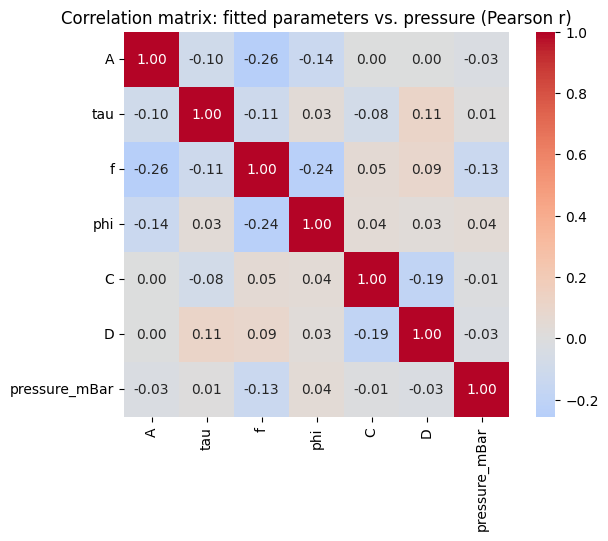

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# compute correlations
corr = df[["A","tau","f","phi","C","D","pressure_mBar"]].corr(method="pearson")

# display numeric values
print(corr["pressure_mBar"].sort_values(ascending=False))

# visualize
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
plt.title("Correlation matrix: fitted parameters vs. pressure (Pearson r)")
plt.show()



**Spearman correlation**

pressure_mBar    1.000000
tau              0.086576
A                0.039819
C               -0.011992
D               -0.033215
f               -0.100537
phi             -0.421193
Name: pressure_mBar, dtype: float64


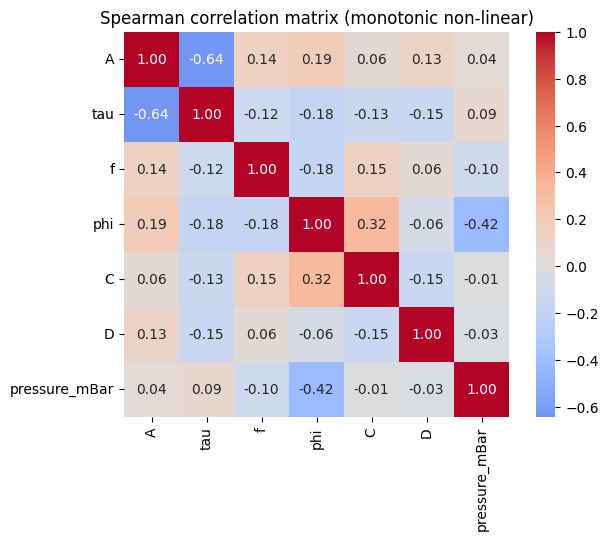

In [ ]:
cols = ["A","tau","f","phi","C","D","pressure_mBar"]

# Spearman rank correlation (captures monotonic non-linear relations)
corr_spear = df[cols].corr(method="spearman")
print(corr_spear["pressure_mBar"].sort_values(ascending=False))

plt.figure(figsize=(7,5))
sns.heatmap(corr_spear, annot=True, fmt=".2f", cmap="coolwarm",
            center=0, square=True)
plt.title("Spearman correlation matrix (monotonic non-linear)")
plt.show()


**non-linear correlation: distance correlation**

a) Define distance correlation

In [ ]:
import numpy as np
import pandas as pd

def distance_correlation(x, y):
    """Distance correlation between two 1D arrays."""
    x = np.atleast_1d(np.asarray(x, dtype=float))
    y = np.atleast_1d(np.asarray(y, dtype=float))
    if x.ndim == 1:
        x = x[:, None]
    if y.ndim == 1:
        y = y[:, None]
    n = x.shape[0]
    if y.shape[0] != n:
        raise ValueError("x and y must have the same length")

    # pairwise Euclidean distances
    a = np.sqrt(((x[:, None, :] - x[None, :, :]) ** 2).sum(axis=2))
    b = np.sqrt(((y[:, None, :] - y[None, :, :]) ** 2).sum(axis=2))

    # double-centered distance matrices
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()

    dcov2_xy = (A * B).sum() / (n ** 2)
    dcov2_xx = (A * A).sum() / (n ** 2)
    dcov2_yy = (B * B).sum() / (n ** 2)

    if dcov2_xx == 0 or dcov2_yy == 0:
        return 0.0

    return np.sqrt(dcov2_xy) / np.sqrt(np.sqrt(dcov2_xx * dcov2_yy))


b) Build a distance-correlation matrix

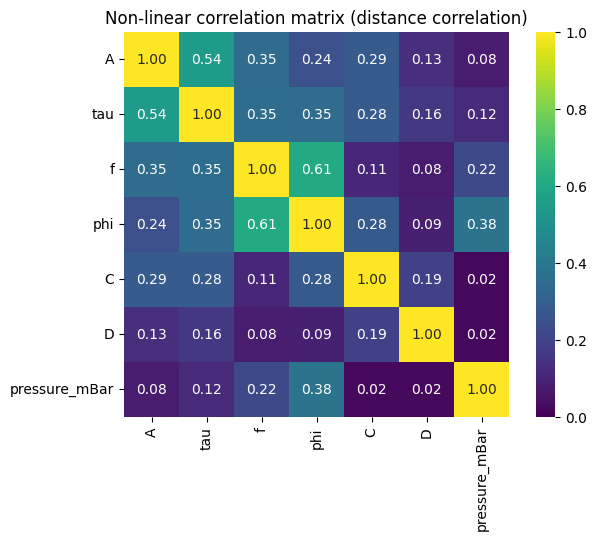


Paires de features les plus corrélées (distance-corr) :
           f  -  phi          : 0.607
           A  -  tau          : 0.545
         phi  -  pressure_mBar : 0.383
         tau  -  f            : 0.354
         tau  -  phi          : 0.349
           A  -  f            : 0.349
           A  -  C            : 0.285
         tau  -  C            : 0.284
         phi  -  C            : 0.281
           A  -  phi          : 0.243
           f  -  pressure_mBar : 0.222
           C  -  D            : 0.190
         tau  -  D            : 0.163
           A  -  D            : 0.134
         tau  -  pressure_mBar : 0.120
           f  -  C            : 0.106
         phi  -  D            : 0.089
           f  -  D            : 0.080
           A  -  pressure_mBar : 0.076
           D  -  pressure_mBar : 0.023
           C  -  pressure_mBar : 0.021


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ["A","tau","f","phi","C","D","pressure_mBar"]

# To keep distance correlation manageable, subsample rows
max_n = 14000  # adjust if needed
df_sub = df[cols].sample(
    n=min(max_n, len(df)),
    random_state=42
)

# compute distance-correlation matrix
n_feat = len(cols)
dcor_mat = np.zeros((n_feat, n_feat))

for i, ci in enumerate(cols):
    for j, cj in enumerate(cols):
        if j < i:
            dcor_mat[i, j] = dcor_mat[j, i]   # symmetry
        elif i == j:
            dcor_mat[i, j] = 1.0
        else:
            dcor_mat[i, j] = distance_correlation(df_sub[ci].values,
                                                  df_sub[cj].values)

dcor_df = pd.DataFrame(dcor_mat, index=cols, columns=cols)

plt.figure(figsize=(7,5))
sns.heatmap(dcor_df, annot=True, fmt=".2f",
            cmap="viridis", vmin=0, vmax=1, square=True)
plt.title("Non-linear correlation matrix (distance correlation)")
plt.show()

# on prend seulement la partie supérieure de la matrice (sans la diagonale)
pairs_sorted = (
    dcor_df.where(np.triu(np.ones(dcor_df.shape), k=1).astype(bool))
           .stack()                      # transforme en Series (index = (feat1, feat2))
           .sort_values(ascending=False) # tri décroissant
)

print("\nPaires de features les plus corrélées (distance-corr) :")
for (f1, f2), val in pairs_sorted.items():
    print(f"{f1:>12}  -  {f2:<12} : {val:.3f}")

